# Genomes as weighted sums of permutations in `cgt`
First, import the package and everything from the enums module. `cgt` includes enums for every set of options so that your editor can provide you with the options available

In [1]:
import cgt
from cgt.enums import *

We can define a `PositionParadigmFramework` under which we will model genomes. We can choose a number of regions to model, whether or not we want to capture orientation of the DNA in those regions, and the symmetry of the genome (for example, linear or circular). For now we will choose to model oriented, circular genomes with 4 regions. Printing the framework shows us a unique string representation.

In [2]:
framework = cgt.PositionParadigmFramework(4, oriented=True, symmetry=SYMMETRY.circular)
print(framework)

Framework for circular genomes with 4 oriented regions


Right away, we can take a look at a genome. By default, genomes are weighted sums of all the permutations we can use to represent them. The larger the symmetry group, the more terms in the sum. We can think of the coefficients as the proability of obtaining the corresponding instance if we arbitrarily fixed the genome positions (ignoring the symmetry).

In [3]:
genome = framework.random_genome()
print(genome)

1/8*(2,4,-2,-4) + 1/8*(1,2)(3,4,-3,-4)(-2,-1) + 1/8*(1,3)(4,-4)(-3,-1) + 1/8*(1,4,-1,-4)(2,3)(-3,-2) + 1/8*(1,-4,-3,2,-1,4,3,-2) + 1/8*(1,-3)(2,-4,-2,4)(3,-1) + 1/8*(1,-2,3,-4,-1,2,-3,4) + 1/8*(1,-1)(2,-2)(3,-3)


We can view the genome in other ways, too. Select a random permutation representing the above genome. These are referred to as genome instances

In [4]:
instance = framework.random_instance(genome)
print(instance)

(1,-2,3,-4,-1,2,-3,4)


Each genome has a canonical instance. Here canonical means the instance which maps region 1 to position 1. The instance is returned in one_row notation.

In [5]:
canonical_instance = framework.canonical_instance(instance)
print(canonical_instance)

[1, 4, 3, -2]


...but can be convered back to cycle notation easily.

In [6]:
canonical_instance = framework.cycles(canonical_instance)
print(canonical_instance)

(2,4,-2,-4)


We can obtain the genome from a given instace, canonical or otherwise.

In [7]:
new_genome = framework.genome(instance, format=FORMAT.formal_sum)
print(genome == new_genome)

True


Below, we can see that the canonical instance from above also represents a linear genome. There are two terms because there are two ways to represent a linear genome, since we can flip the whole genome over.

In [8]:
print(cgt.PositionParadigmFramework(4, symmetry=SYMMETRY.linear).genome(canonical_instance, format=FORMAT.formal_sum))

1/2*(2,4,-2,-4) + 1/2*(1,-4,-3,2,-1,4,3,-2)


In general though, it is best to not move between frameworks like this.

# Defining a model

To model genome rearrangements, we need to define a set of possible rearrangements, and the probability each rearrangement has of occuring. This is simple to do in `cgt` for a range of different models. Below we define a model allowing inversions of single regions or pairs of adjacent regions, and specify that it is twice as likely to see a single region inversion. We can print the model's `generating_dictionary` to see the permutations that generate the model under conjugation by the symmety group.

In [9]:
model = cgt.Model.named_model_with_relative_probs(framework, {
    cgt.MODEL.one_region_inversions: 2/3,
    cgt.MODEL.two_region_inversions: 1/3
})
print(model.generating_dictionary)

{(1,-1): 2/3, (1,-2)(2,-1): 1/3}


We can also obtain the `s` element as defined in [how do I do references in a notebook??]

In [10]:
s = model.s_element(in_algebra=ALGEBRA.genome)
print(s, '\n ...or, in the group algebra:\n', model.s_element(in_algebra=ALGEBRA.group))

1/3*(1,-2)(2,-1) + 2/3*(1,-1) 
 ...or, in the group algebra:
 1/6*(4,-4) + 1/12*(3,-4)(4,-3) + 1/6*(3,-3) + 1/12*(2,-3)(3,-2) + 1/6*(2,-2) + 1/12*(1,-4)(4,-1) + 1/12*(1,-2)(2,-1) + 1/6*(1,-1)


To obtain the 'model element' in the genome algebra, we can multiply `s` by the symmetry element. Note that the order of the multiplication is reveresed, since `SageMath` multiplies permutations from left to right.

In [11]:
z = framework.symmetry_element()
zs = s*z
print(zs)

1/24*(3,-4)(4,-3) + 1/12*(2,-4)(3,-3)(4,-2) + 1/24*(1,2,3,-1,-2,-3)(4,-4) + 1/12*(1,2,-1,-2)(3,-4)(4,-3) + 1/24*(1,3,-2,-4)(2,4,-1,-3) + 1/12*(1,3,-1,-3)(2,-2)(4,-4) + 1/24*(1,4,-2,-1,-4,2)(3,-3) + 1/12*(1,4,-1,-4)(2,-3)(3,-2) + 1/12*(1,-4,-3,-2,-1,4,3,2) + 1/24*(1,-4,-2,3)(2,-3,-1,4) + 1/12*(1,-3,-1,3)(2,4)(-4,-2) + 1/24*(1,-3,-4,-1,3,4)(2,-2) + 1/12*(1,-2,-3,-4,-1,2,3,4) + 1/24*(1,-2)(2,-1) + 1/12*(1,-1) + 1/24*(1,-1)(2,-4,-3,-2,4,3)


# Applying rearrangements

not done yet!

# Computing maximum likelihood estimates

One of the primary purposes of `cgt` is computing likelihood functions for time elapsed during the transformation from the reference genome into a given genome. The computation involves computing irreducible representations and projection matrices, but the syntax for computing the estimates is straightforward. For this notebook, we will take genomes with just 4 regions, because the initial computation of the irreducibles is not instant for larger numbers of regions. Note however that `cgt` will only compute these irreps once for each framework.

First, take a particular genome instance of interest, and compute the likelihood function.

In [12]:
from cgt.distances import likelihood_function
instance = framework.cycles([1, -2, 3, -4])
L = likelihood_function(framework, model, instance, attempt_exact=True)

We can of course evaluate the likelihood function at a given point very quickly

In [13]:
print([round(L(t), 4) for t in [0, 2, 4, 8]])

[0.0, 0.0196, 0.0229, 0.0214]


More importantly, we can obtain the maximum

In [14]:
from cgt.distances import maximise
maximise(framework, L)

3.794389749020202

The maximise function requires the framework, because it uses additional information to aid the optimiser. Specifically, it uses the fact that the likelihood function converges to the inverse of the number of genomes 

In [15]:
print(f"Function should converge to {float(framework.symmetry_group().order()/framework.genome_group().order())}")

Function should converge to 0.020833333333333332


We can plot the likelihood function using `matplotlib`'s `pyplot` module to verify both the MLE and the convergence to the above value

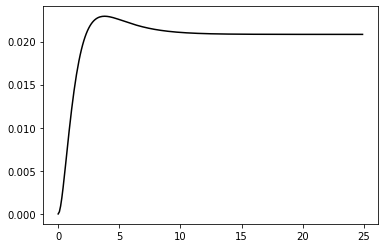

In [16]:
import numpy as np
from matplotlib import pyplot
times = np.arange(0, 25, 0.1)
pyplot.plot(times, [L(t) for t in times], color='black')

Note also that there are shorthands for obtaining the MLEs directly without needing to first obtain the likelihood functions:

In [18]:
from cgt.distances import mle, mles
single_mle = mle(framework, model, instance)
multiple_mles = mles(framework, model, [instance, framework.cycles([1,2,3,-4]), framework.cycles([1,-3,-4,-2])])

print(single_mle)
print(multiple_mles)

3.7943883204506883
{(2,-2)(4,-4): 3.7943883204506883, (4,-4): 1.2164942500236173, (2,-3,4,-2,3,-4): nan}


# Computing other distance estimates

not done yet!